# Importing libraries

In [1]:
import json
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# RMSE Comparisons

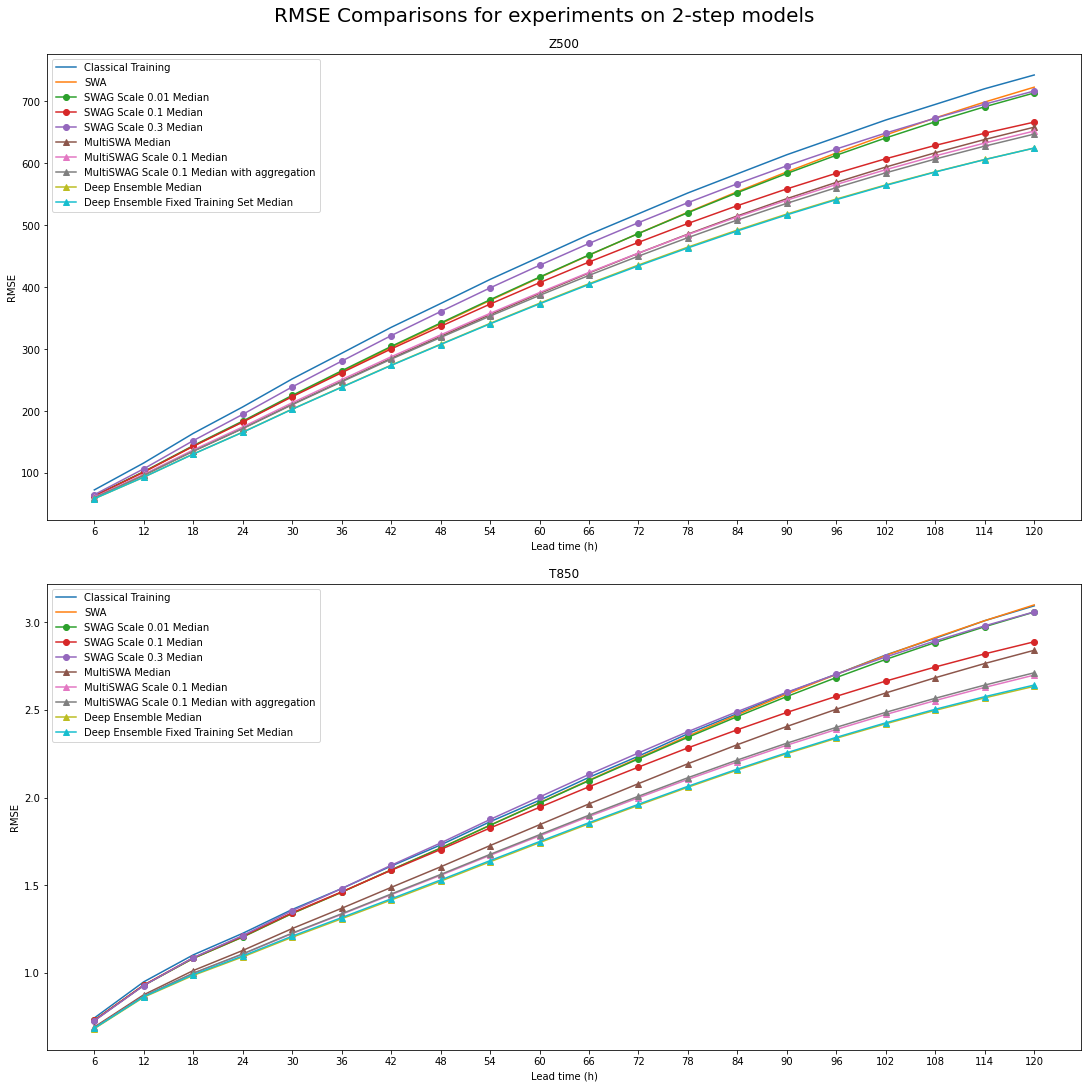

In [2]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_epoch_{ep}',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale001_median',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale01_median',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale03_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_aggregate_median',
    description_epoch + f'_s02_ensemble_epoch_{ep}_median',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_{ep}_median'
]

labels = [
    'Classical Training',
    'SWA',
    'SWAG Scale 0.01 Median',
    'SWAG Scale 0.1 Median',
    'SWAG Scale 0.3 Median',
    'MultiSWA Median',
    'MultiSWAG Scale 0.1 Median',
    'MultiSWAG Scale 0.1 Median with aggregation',
    'Deep Ensemble Median',
    'Deep Ensemble Fixed Training Set Median'
]

markers = ['', '', 'o', 'o', 'o', '^', '^', '^', '^', '^']

file_paths = []

for description in descriptions:
    rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'    
    file_paths.append(rmse_filename)

rmses = []
    
for path in file_paths:
    rmse = xr.open_dataset(path)
    rmses.append(rmse)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, rmse in enumerate(rmses):
    ax1.plot(lead_times, rmse.z.values, label=labels[i], marker=markers[i])
    
for i, rmse in enumerate(rmses):
    ax2.plot(lead_times, rmse.t.values, label=labels[i], marker=markers[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('RMSE')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('RMSE Comparisons for experiments on 2-step models', fontsize=20)
ax1.legend()
ax2.legend()
plt.show()

In [3]:
def table(rmses, labels):
    rows = []
    for i, rmse in enumerate(rmses):
        row = {
            'Model': labels[i],
            'Z500 6H': round(rmse.sel(lead_time=6).z.item(), 3), 
            'Z500 120H':round(rmse.sel(lead_time=120).z.item(), 3), 
            'T850 6H': round(rmse.sel(lead_time=6).t.item(), 3),
            'T850 120H':round(rmse.sel(lead_time=120).t.item(), 3)
        }
        rows.append(row)

    df = pd.DataFrame(rows).set_index('Model')
    
    return df

In [4]:
df_rmses_single = table(rmses[:5], labels[:5])
df_rmses_single

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
Classical Training,72.780,742.754,0.743,3.093
SWA,63.004,723.077,0.730,3.099
SWAG Scale 0.01 Median,63.246,713.748,0.729,3.058
SWAG Scale 0.1 Median,62.845,666.662,0.729,2.888
SWAG Scale 0.3 Median,65.080,716.906,0.727,3.059


In [5]:
df_rmses_ens = table([rmses[0]] + rmses[5:], [labels[0]] + labels[5:])
df_rmses_ens

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
Classical Training,72.780,742.754,0.743,3.093
MultiSWA Median,60.102,658.468,0.691,2.840
MultiSWAG Scale 0.1 Median,60.984,652.228,0.685,2.698
MultiSWAG Scale 0.1 Median with aggregation,60.112,647.285,0.686,2.711
Deep Ensemble Median,58.567,624.798,0.682,2.634
Deep Ensemble Fixed Training Set Median,58.613,624.734,0.684,2.642


# CRPS Comparisons

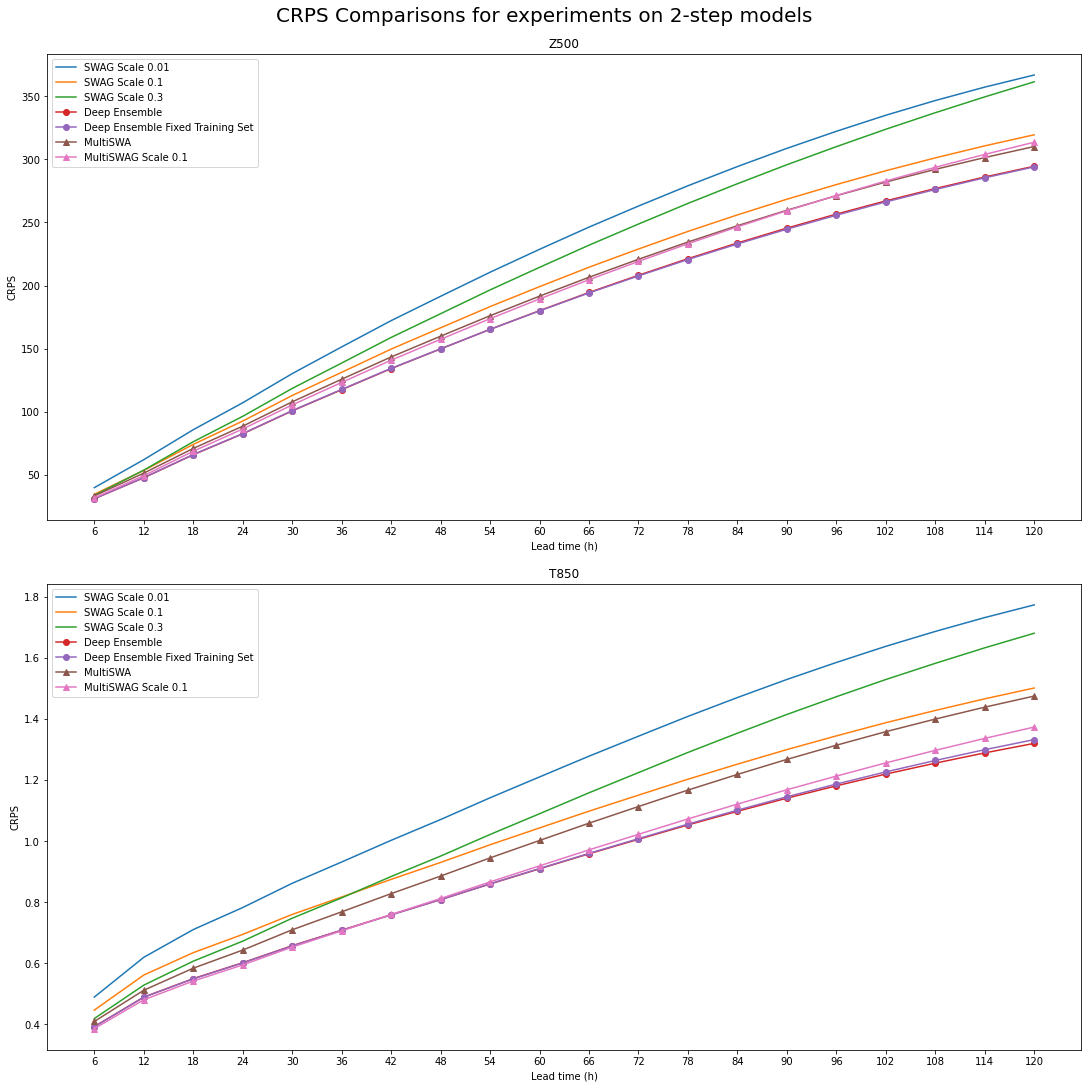

In [7]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale001',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale01',
    description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale03',
    description_epoch + '_s02_ensemble_epoch_11',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_11',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01'
]

labels = [
    'SWAG Scale 0.01',
    'SWAG Scale 0.1',
    'SWAG Scale 0.3',
    'Deep Ensemble',
    'Deep Ensemble Fixed Training Set',
    'MultiSWA',
    'MultiSWAG Scale 0.1'
]

markers = ['', '', '', 'o', 'o', '^', '^']

file_paths = []

for description in descriptions:
    crps_filename = datadir + 'metrics/crps_' + description + '.nc'    
    file_paths.append(crps_filename)

crps_list = []
    
for path in file_paths:
    crps = xr.open_dataset(path)
    crps_list.append(crps)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, crps in enumerate(crps_list):
    ax1.plot(lead_times, crps.z.values, label=labels[i], marker=markers[i])
    
for i, crps in enumerate(crps_list):
    ax2.plot(lead_times, crps.t.values, label=labels[i], marker=markers[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('CRPS')
ax2.set_ylabel('CRPS')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('CRPS Comparisons for experiments on 2-step models', fontsize=20)
ax1.legend()
ax2.legend()
plt.show()

In [8]:
df_crps = table(crps_list, labels)
df_crps

,Z500 6H,Z500 120H,T850 6H,T850 120H
Model,,,,
SWAG Scale 0.01,40.009,366.759,0.489,1.774
SWAG Scale 0.1,34.771,319.416,0.447,1.501
SWAG Scale 0.3,33.953,361.372,0.419,1.681
Deep Ensemble,31.251,294.512,0.393,1.320
Deep Ensemble Fixed Training Set,31.310,293.995,0.392,1.332
MultiSWA,33.477,310.111,0.409,1.475
MultiSWAG Scale 0.1,31.911,313.528,0.386,1.374
